In [26]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from robocop import fetch_events,evaluate_and_report2,build_pid_windows,evaluate_and_report,build_pid_and_handle_windows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [27]:
NUM_SYSCALLS = 473 + 1 # State Of PADDING
PADDING_SYSCALL = 473
PADDING_OBJ = {'id': 0,
   'ts': 0,
   'pid': 0,
   'tid': 0,
   'syscall_num': PADDING_SYSCALL,
   'process_name': 0,
   'handle_operation': None,
   'handle_1_val': None,
   'handle_2_val': None,
   'ret_handle': None,
   'closed_handle': None,
   'handle_1_access': None,
   'handle_2_access': None,
   'handle_1_access_mode': None,
   'handle_2_access_mode': None,}
NGRAM = 4
NU = 0.01
GAMMA = 0.01

In [28]:
encoder = OneHotEncoder(
    categories=[np.arange(NUM_SYSCALLS)],
    sparse_output=False,
    handle_unknown="ignore"
)

# fit once
encoder.fit(np.zeros((1, 1), dtype=np.float64))


encoder2 = OneHotEncoder(
    categories=[np.arange(3)],
    sparse_output=False,
    handle_unknown="ignore"
)

# fit once
encoder2.fit(np.zeros((1, 1), dtype=np.float64))

OneHotEncoder(categories=[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106...
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
       455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
       468, 469, 470, 471, 472, 473])],
              handle_unknown='ignore', sparse_output=False)

In [51]:
import json 

with open("windows_22h2_weights.json",'r') as file: 
    json_weights = json.load(file)

weights = { info["number"] : info["weight"] for name,info in json_weights.items() }
weights[473] = 0

def extract_features(window,open_reasosn):
    x = np.array([i for i,_ in window], dtype=np.int32).reshape(-1, 1)
    onehot = encoder.transform(x)
    times = [ts for _,ts in window if ts]
    diff_ts =  float((max(times) - min(times))) if times else 0.0
    handle_operation = encoder.transform([[open_reasosn]])[0]
    return np.append(np.append(np.append(np.asarray(onehot.sum(axis=0),dtype=np.float64).ravel(),sum(weights.get(i, 0.0) for i,_ in window)),diff_ts),handle_operation)

def build_X(handles_seq, syscall_to_id=None): 
    vectors = [] 
    mapping = []  
    for handles in handles_seq:
        buf = []
        open_reason = 0 
        for handle in handles:
            if handle["handle_operation"]:
                open_reason = handle["handle_operation"]
                
            if len(buf) == NGRAM: 
                vectors.append(extract_features(buf,open_reason))
                mapping.append(handles)  
                buf = buf[1:]
            buf.append((handle["syscall_num"],handle["ts"]))
        
        if len(buf) == NGRAM: 
            vectors.append(extract_features(buf,open_reason))
            mapping.append(handles)
        else:
            for i in range(NGRAM - len(buf)): 
                buf.append((PADDING_SYSCALL,None))
            vectors.append(extract_features(buf,open_reason))
            mapping.append(handles)

    return vectors, mapping   


In [30]:
train_events = fetch_events("test = '1' OR test = '2' OR test='15' OR test='14' OR test='15' OR test='16' OR test='17'")

In [31]:
len(train_events)

626110

In [32]:
import robocop
from collections import defaultdict
def build_pid_and_handle_windows_set_and_weights(events):
    handle_pid_cache = defaultdict(lambda : (list(),set()))
    windows = []
    general_windows = [] 
    def extract_handles(e):
        handles = [] 
        if e["handle_1_val"]:
            yield e["handle_1_val"]
        if e["handle_2_val"]:
            yield e["handle_2_val"]
            
    for e in events:
        e['name'] = robocop.convert_syscall_num_to_string(e['syscall_num'])
        pid = e["pid"]
        
        for handle in extract_handles(e):
            buf,cache = handle_pid_cache[(pid,handle)]
            if buf or handle > 0x8000000000000000: 
                if (sn:=e["syscall_num"]) not in cache:
                    buf.append(e)
                    cache.add(sn)
        
        if rh := e["ret_handle"]: 
            buf,cache = handle_pid_cache[(pid,rh)]
            if (sn:=e["syscall_num"]) not in cache:
                buf.append(e)
                cache.add(sn)
            
        
        if ch := e["closed_handle"]: 
            buf,cache = handle_pid_cache[(pid,ch)]
            if buf or handle > 0x8000000000000000:
                if (sn:=e["syscall_num"]) not in cache:
                    buf.append(e)
                    cache.add(sn)
                windows.append(list(buf))
                cache.clear()
                buf.clear()

   #for ((proc,handle),group_self),cache in handle_pid_cache.items(): 
    #    if handle > 0x8000000000000000 and group_self: 
     #        windows.append(list(group_self))

    return windows

In [33]:
train_windows = build_pid_and_handle_windows_set_and_weights(train_events)
train_windows


[[{'id': 341,
   'ts': 1768424195751936.0,
   'pid': 992,
   'tid': 6200,
   'syscall_num': 66,
   'process_name': 'ation\\chrome.exe',
   'handle_operation': 1,
   'handle_1_val': 3336,
   'handle_2_val': None,
   'ret_handle': 6960,
   'closed_handle': None,
   'handle_1_access': 2,
   'handle_2_access': None,
   'handle_1_access_mode': 224,
   'handle_2_access_mode': None,
   'name': 'NtDuplicateToken'},
  {'id': 342,
   'ts': 1768424195751936.0,
   'pid': 992,
   'tid': 6200,
   'syscall_num': 13,
   'process_name': 'ation\\chrome.exe',
   'handle_operation': None,
   'handle_1_val': 6960,
   'handle_2_val': None,
   'ret_handle': None,
   'closed_handle': None,
   'handle_1_access': 4,
   'handle_2_access': None,
   'handle_1_access_mode': 224,
   'handle_2_access_mode': None,
   'name': 'NtSetInformationThread'},
  {'id': 343,
   'ts': 1768424195751936.0,
   'pid': 992,
   'tid': 6200,
   'syscall_num': 15,
   'process_name': 'ation\\chrome.exe',
   'handle_operation': None,
   '

In [52]:
X_train,mapping = build_X(train_windows)


In [44]:
len(X_train)

38841

In [53]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

In [57]:
virus_events = fetch_events("test = '8' OR test='5' OR test='10' OR test='9' OR test='12'")


In [58]:
len(virus_events)

932124

In [59]:
virus_windows = build_pid_and_handle_windows_set_and_weights(virus_events)
X_virus,virus_mapping = build_X(virus_windows)

In [60]:
len(X_virus)

72289

In [61]:
normal_events = fetch_events("test = '15' OR test ='16' OR test='17'")

In [62]:
normal_windows = build_pid_and_handle_windows_set_and_weights(normal_events)
X_normal,normla_mapping= build_X(normal_windows)

In [63]:
len(normal_windows)

8340

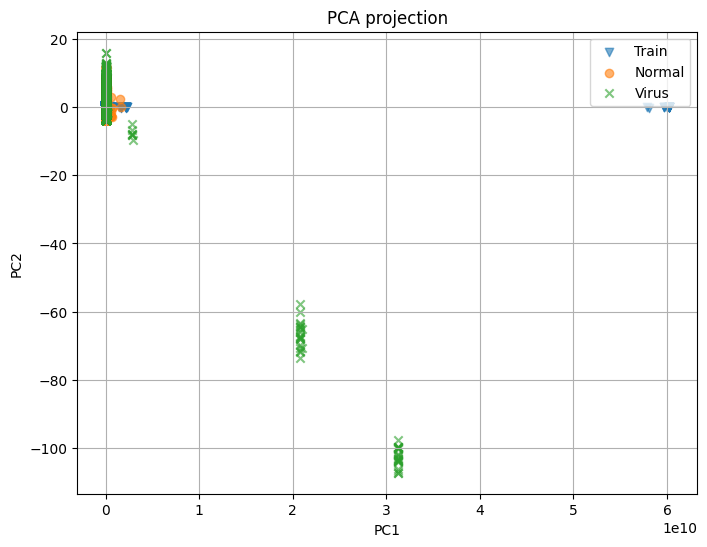

In [64]:
x_train_2d = X_2d
X_normal_2d = pca.fit_transform(X_normal)
X_virus_2d  = pca.transform(X_virus)   # project to same PCA space

plt.figure(figsize=(8, 6))

plt.scatter(
    x_train_2d[:, 0], x_train_2d[:, 1],
    alpha=0.6, label="Train", marker="v"
)

plt.scatter(
    X_normal_2d[:, 0], X_normal_2d[:, 1],
    alpha=0.6, label="Normal", marker="o"
)

plt.scatter(
    X_virus_2d[:, 0], X_virus_2d[:, 1],
    alpha=0.6, label="Virus", marker="x"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection")
plt.legend()
plt.grid(True)

plt.show()

In [65]:
from collections import defaultdict
import robocop
def evaluate_and_report(label: str, windows, X, model, scaler):
    X_scaled = scaler.transform(X)
    preds = model.predict(X_scaled)                 # +1 normal, -1 anomaly
    scores = model.decision_function(X_scaled)      # more negative => more anomalous
    totatl = [] 

    for i, (p, s) in enumerate(zip(preds, scores)):
        if p != -1:
            continue
        
        w = windows[i]
        proc_name = w[0]["process_name"]
        pid = w[0]["pid"]
        syscalls = [robocop.convert_syscall_num_to_string(e["syscall_num"]) for e in w]

        totatl.append({
                "pid": pid,
                "name" : proc_name,
                "score": float(s),
                "syscalls": syscalls,
            })

    return totatl


In [66]:
import matplotlib.pyplot as plt

def plot_process_all_scores(results, process_name):
    scores = [r["score"] for r in results if r["name"] == process_name]

    if not scores:
        print(f"No scores found for process: {process_name}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(scores, marker='o')
    plt.axhline(0, linestyle="--")

    plt.title(f"OCSVM scores for process: {process_name}")
    plt.xlabel("Window index")
    plt.ylabel("OCSVM score (lower = more anomalous)")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [67]:

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
model = OneClassSVM(kernel="rbf", nu=0.01, gamma=0.01)
model.fit(X_train_scaled)


OneClassSVM(gamma=0.01, nu=0.01)

In [68]:
normal_report = evaluate_and_report(
    label="NORMAL",
    windows=normla_mapping,
    X=X_normal,
    model=model,
    scaler=scaler
)
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=virus_mapping,
    X=X_virus,
    model=model,
    scaler=scaler
)
print(f"NU : VIRUS:{len(virus_report)} NORMAL:{len(normal_report)}")

NU : VIRUS:3064 NORMAL:409


In [69]:
normal_report

[{'pid': 2752,
  'name': 'efox\\firefox.exe',
  'score': -0.00011999987155153491,
  'syscalls': ['NtCreateFile',
   'NtReadFile',
   'NtFlushBuffersFileEx',
   'NtClose']},
 {'pid': 2752,
  'name': 'efox\\firefox.exe',
  'score': -0.00011999987155153491,
  'syscalls': ['NtCreateFile',
   'NtReadFile',
   'NtFlushBuffersFileEx',
   'NtClose']},
 {'pid': 2752,
  'name': 'efox\\firefox.exe',
  'score': -0.0001263451750146416,
  'syscalls': ['NtCreateFile',
   'NtLockFile',
   'NtSetInformationFile',
   'NtQueryInformationFile',
   'NtUnloadKeyEx',
   'NtCreateSection',
   'NtClose']},
 {'pid': 2752,
  'name': 'efox\\firefox.exe',
  'score': -5.7941314372200736e-05,
  'syscalls': ['NtCreateFile',
   'NtQueryInformationFile',
   'NtFlushBuffersFileEx',
   'NtReadFile',
   'NtSetInformationFile',
   'NtClose']},
 {'pid': 2752,
  'name': 'efox\\firefox.exe',
  'score': -0.00042419137443960864,
  'syscalls': ['NtCreateFile',
   'NtQueryInformationFile',
   'NtFlushBuffersFileEx',
   'NtReadFil

In [70]:
virus_report

[{'pid': 4476,
  'name': 'tem32\\ctfmon.exe',
  'score': -0.00024693236711392785,
  'syscalls': ['NtOpenThread', 'NtClose']},
 {'pid': 4476,
  'name': 'tem32\\ctfmon.exe',
  'score': -0.00024693236711392785,
  'syscalls': ['NtOpenThread', 'NtClose']},
 {'pid': 3560,
  'name': 'enguestagent.exe',
  'score': -8.311724915444074e-06,
  'syscalls': ['NtCreateTimer', 'NtSetTimer2', 'NtClose']},
 {'pid': 1832,
  'name': 'eteDllLoader.exe',
  'score': -8.740993027256394e-05,
  'syscalls': ['NtOpenSymbolicLinkObject',
   'NtQuerySymbolicLinkObject',
   'NtClose']},
 {'pid': 1832,
  'name': 'eteDllLoader.exe',
  'score': -4.2310957202751354e-05,
  'syscalls': ['NtCreateSection', 'NtSaveMergedKeys', 'NtClose']},
 {'pid': 1104,
  'name': 'em32\\conhost.exe',
  'score': -0.00010761802775149931,
  'syscalls': ['NtOpenProcessTokenEx',
   'NtQuerySecurityAttributesToken',
   'NtQueryInformationToken',
   'NtClose']},
 {'pid': 1832,
  'name': 'eteDllLoader.exe',
  'score': -1.8856387878933,
  'syscalls

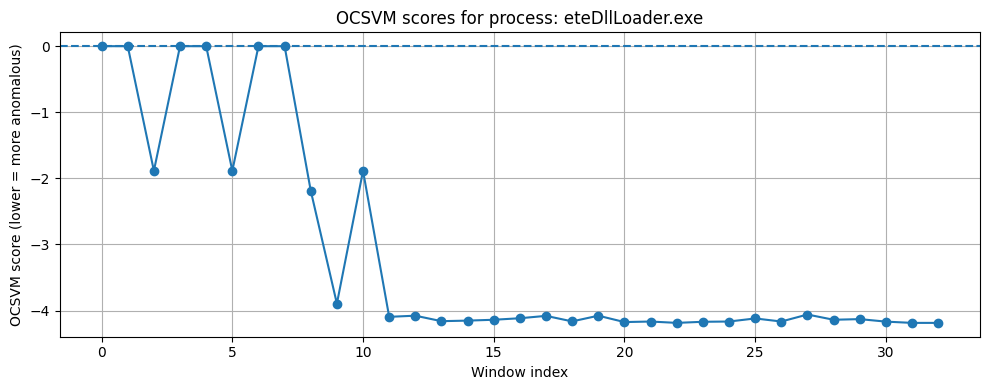

In [76]:
plot_process_all_scores(virus_report,'eteDllLoader.exe')

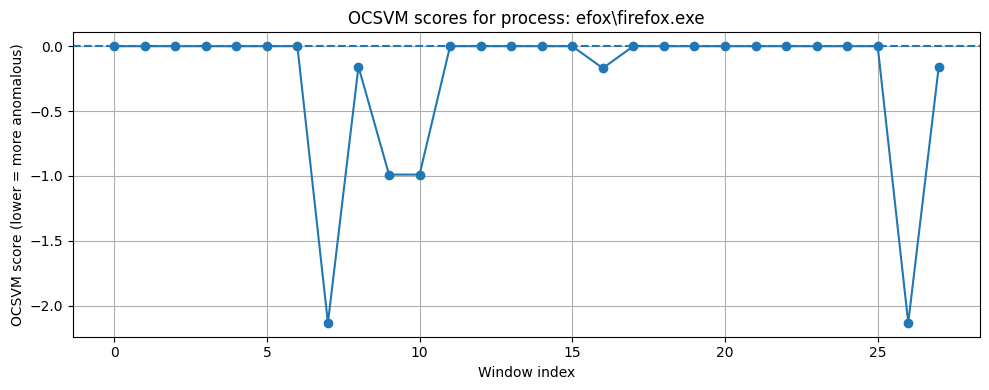

In [72]:
plot_process_all_scores(normal_report,'efox\\firefox.exe')

In [ ]:
virus_report

[{'pid': 4476,
  'name': 'tem32\\ctfmon.exe',
  'score': -6.030209179019863e-05,
  'syscalls': ['NtOpenThread', 'NtClose']},
 {'pid': 4476,
  'name': 'tem32\\ctfmon.exe',
  'score': -6.030209179019863e-05,
  'syscalls': ['NtOpenThread', 'NtClose']},
 {'pid': 3560,
  'name': 'enguestagent.exe',
  'score': -0.00022405234247546701,
  'syscalls': ['NtAllocateVirtualMemory', 'NtClose']},
 {'pid': 2920,
  'name': 'perienceHost.exe',
  'score': -0.00022405234247546701,
  'syscalls': ['NtAllocateVirtualMemory', 'NtClose']},
 {'pid': 4612,
  'name': '0\\powershell.exe',
  'score': -0.00022405234247546701,
  'syscalls': ['NtAllocateVirtualMemory', 'NtClose']},
 {'pid': 1832,
  'name': 'eteDllLoader.exe',
  'score': -2.0285128046637624e-05,
  'syscalls': ['NtOpenSymbolicLinkObject',
   'NtQuerySymbolicLinkObject',
   'NtClose']},
 {'pid': 1832,
  'name': 'eteDllLoader.exe',
  'score': -9.0688914740511e-05,
  'syscalls': ['NtCreateSection', 'NtSaveMergedKeys', 'NtClose']},
 {'pid': 1104,
  'name':

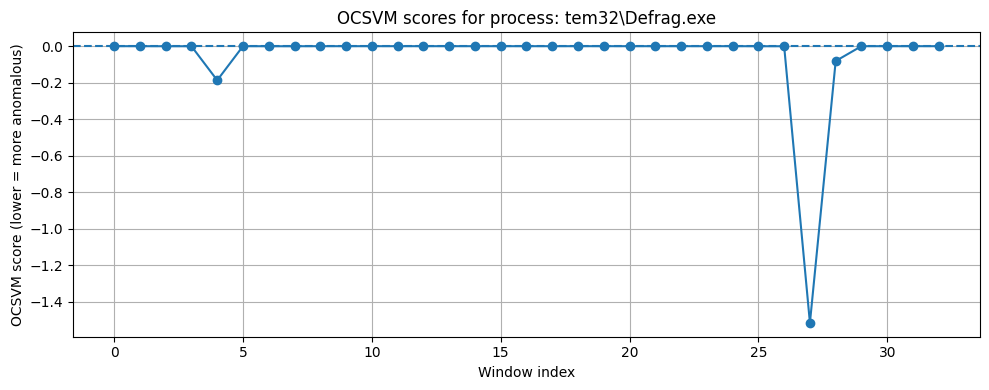

In [78]:
plot_process_all_scores(virus_report, 'tem32\\Defrag.exe')

In [ ]:
'em32\\dllhost.exe'

'em32\\dllhost.exe'

In [75]:
open("noder.virus",'w').write(str("\n".join(str(i) for i in virus_report)))

501436

In [ ]:
open("normal.not_virus",'w').write(str("\n".join(str(i) for i in normal_report)))

95165